# TFC - DEISI258 - Modelamento multi-agente de interações em grupos sociais

Aluno: **Paulo Pinto** a21906966

Orientador: **Manuel Marques Pita**


Neste notebook:
- É feita a conexão ao NetLogo através da biblioteca pyNetLogo
- É carregado o modelo desenvolvido para o âmbito do TFC
- A simulação é executada 50 vezes, para obter significância estatística
- Os dados são visualizados e analisados

## Setup

### Setup Virtual Environment

Create virtual environment 'venv' -> `python3 -m venv venv` or `python3.[version_number] -m venv venv`

Activate 'venv' -> Linux `source venv/bin/activate` | Windows `. venv\scripts\activate`

Install required packages -> `pip install -r requirements.txt`

Errors - 
- `No module named 'pip'` -> python -m ensurepip
- `No module named 'jpype'` -> pip install jpype1

### Imports

In [1]:
import os
from sys import platform

import pyNetLogo

import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from collections import Counter

import seaborn as sns

### Connect to NetLogo and Load model

Add NetLogo installation path to environment variables

In [2]:
# check if NetLogo env var exists
if "NetLogo" in os.environ: 
    print(f"{os.environ['NetLogo']=}")
else:
    print("NetLogo not found in environment variables, adding it...")

    # substitute with your NetLogo installation path
    if platform == "linux":
        os.environ["NetLogo"] = "/home/paulo/Desktop/TFC/NetLogo-6.2.1-64/NetLogo 6.2.1"

os.environ['NetLogo']='/home/paulo/Desktop/TFC/NetLogo-6.2.1-64/NetLogo 6.2.1'


Loading model

In [3]:
# connect to netlogo
netlogo = pyNetLogo.NetLogoLink(
    gui=False,
    netlogo_home = os.environ['NetLogo'],
    netlogo_version="6.2",
)

def load_model():
    if platform == "linux":
        model_path = os.path.abspath(os.getcwd()) + "/files/knowledge_units_with_board.nlogo"    
    elif platform == "win32":
        model_path = os.path.abspath(os.getcwd()) + "\\files\\knowledge_units_with_board.nlogo"

    netlogo.load_model(model_path)
    # netlogo.command("set number_of_agents 5")
    netlogo.command("setup")

load_model()

14 agents left
13 agents left
12 agents left
11 agents left
10 agents left
9 agents left
8 agents left
7 agents left
6 agents left
5 agents left
4 agents left
3 agents left
2 agents left
1 agents left
0 agents left

MF RATIO -> F - 7 | M - 8


In [3]:
# todo -> 
# reduce vars -> simplify netlogo code

# multithreading for running all sims at once ! https://docs.python.org/3/library/multiprocessing.html

## Get some data

In [9]:
def replace_cols(df):
    df.rename(columns = {
        'compat_ratio':'Topic Divergence',
        '[ratio] of one-of boards':'Avg Compat Ratio',
        'length last [board_history] of one-of boards':'Burst Length',
        '[male_participation] of one-of boards':'Male Participation',
        '[female_participation] of one-of boards':'Female Participation',
    }, inplace = True)
    return df

# gets messages, returns in/out of topic lengths
# [1, 0, 0, 0, 1, 1] -> [[3], [1, 2]]
def split_topics(messages):
    topic = [[],[]]

    prev_compat = 1

    for curr_compat in messages:
        if curr_compat == -1 or curr_compat == "-1": curr_compat = 0
        if prev_compat == curr_compat: # continue last count
            topic[curr_compat][len(topic[curr_compat]) - 1] += 1
        else: # create new count
            topic[curr_compat].append(1)
        
        prev_compat = curr_compat
    
    return topic

In [89]:
netlogo.command("set female_prob_exploit 0.45")
netlogo.command("set male_prob_exploit 0.45")
netlogo.command("set number_of_agents 15")
netlogo.command('set Method "Attention Norm - General"') # General / General Fix

simulation_times = 50
iterations = 300

simulation_reports = []

for _ in range(simulation_times):
    netlogo.command("setup")
    report = netlogo.repeat_report(\
        ["compat_ratio", "[ratio] of one-of boards", "length last [board_history] of one-of boards"],\
    iterations)
    report = replace_cols(report)
    # topic_divergence = netlogo.repeat_report(["compat_ratio"], iterations)
    simulation_reports.append(report)
    print(_)

14 agents left
13 agents left
12 agents left
11 agents left
10 agents left
9 agents left
8 agents left
7 agents left
6 agents left
5 agents left
4 agents left
3 agents left
2 agents left
1 agents left
0 agents left

MF RATIO -> F - 8 | M - 7
0
14 agents left
13 agents left
12 agents left
11 agents left
10 agents left
9 agents left
8 agents left
7 agents left
6 agents left
5 agents left
4 agents left
3 agents left
2 agents left
1 agents left
0 agents left

MF RATIO -> F - 8 | M - 7
1
14 agents left
13 agents left
12 agents left
11 agents left
10 agents left
9 agents left
8 agents left
7 agents left
6 agents left
5 agents left
4 agents left
3 agents left
2 agents left
1 agents left
0 agents left

MF RATIO -> F - 8 | M - 7
2
14 agents left
13 agents left
12 agents left
11 agents left
10 agents left
9 agents left
8 agents left
7 agents left
6 agents left
5 agents left
4 agents left
3 agents left
2 agents left
1 agents left
0 agents left

MF RATIO -> F - 7 | M - 8
3
14 agents left
13 agents

## Write Sims to respective files

In [90]:
for i, sim in enumerate(simulation_reports):
    sim.to_csv(f"outputs/sim_0.45_old/{i}.csv")

In [23]:
def plot_topic_histogram(in_topic, out_topic, method, normalised=False):
    fig = plt.figure(figsize=(10,4))
    fig.patch.set_facecolor('white')

    common_params = {
        "bins" : range(min(in_topic), max(in_topic) + 1, 1),
        "edgecolor" : "black",
        "alpha" : 0.3,
        "density" : normalised
    }

    plt.hist(in_topic, label="in topic", color="red", **common_params)
    plt.hist(out_topic, label="out of topic", **common_params)
    plt.xlabel("Length", size=14)
    plt.ylabel("Count", size=14)
    plt.title(f"Length of In-Topic and Out-of-Topic discussion - {method=}")
    plt.legend(loc='upper right')
    plt.show()

def plot_one_topic_histogram(topic, topic_type, method, normalised=False):
    fig = plt.figure(figsize=(10,4))
    fig.patch.set_facecolor('white')

    common_params = {
        "bins" : range(min(in_topic), max(in_topic) + 1, 1),
        "edgecolor" : "black",
        "color" : "blue" if topic_type == "in" else "red",
        "alpha" : 1,
        "density" : normalised
    }
        
    plt.hist(topic, label=f"{topic_type} topic", **common_params)
    plt.xlabel("Length", size=14)
    plt.ylabel("Count", size=14)
    plt.title(f"Length of {topic_type}-Topic discussion - {method=}")
    plt.legend(loc='upper right')
    
    plt.xlim(0, 100)
    
    # if normalised: not tested
    #     plt.ylim(0.3)
    
    plt.show()




[[2, 30], [2, 267]]
[[35, 261], [5]]
[[301], []]
[[1, 2, 1, 290], [2, 1, 4]]
[[1, 1, 3, 4, 3], [2, 2, 7, 1, 277]]
[[3, 1, 34, 3, 1], [1, 1, 1, 23, 233]]
[[301], []]
[[1], [300]]
[[301], []]
[[1, 3, 1, 3, 1, 42, 3], [3, 4, 1, 58, 1, 142, 38]]
[[9, 1, 1, 14], [1, 5, 2, 268]]
[[2, 10, 2, 19, 5, 1, 236], [2, 5, 3, 5, 6, 5]]
[[1, 1, 35, 1, 1, 1], [4, 9, 1, 1, 1, 245]]
[[1, 1, 2, 4, 289], [1, 1, 1, 1]]
[[301], []]
[[6, 4, 5, 2, 79, 79], [8, 101, 9, 6, 2]]
[[1, 18, 2, 205], [12, 13, 50]]
[[301], []]
[[1, 27, 265], [4, 4]]
[[1, 18, 4, 1, 14, 4, 1, 1], [7, 3, 1, 1, 7, 1, 3, 234]]
[[301], []]
[[25, 1, 5, 50, 9, 69], [1, 15, 1, 124, 1]]
[[2, 76, 2, 4, 1, 1, 1, 6, 2, 5, 3, 9], [2, 1, 28, 1, 3, 60, 1, 33, 10, 1, 1, 48]]
[[7, 6, 21, 2, 1, 2, 1, 1, 7, 25], [4, 1, 150, 4, 2, 2, 59, 5, 1]]
[[1, 4, 3], [21, 52, 220]]
[[11, 1, 15, 21, 139], [2, 2, 109, 1]]
[[37, 5, 11, 3, 2, 15, 2, 9, 1, 3, 29], [83, 1, 1, 15, 2, 10, 2, 16, 1, 30, 23]]
[[4, 1, 2, 2, 1, 4, 1, 55], [1, 76, 10, 6, 2, 19, 1, 116]]
[[1, 4, 4,

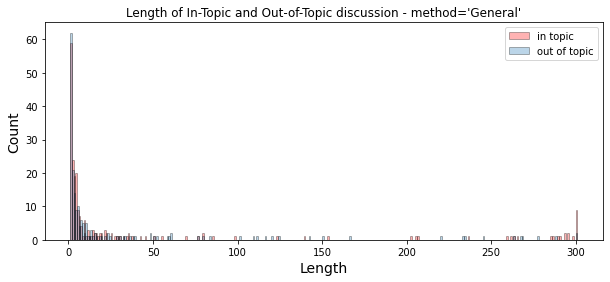

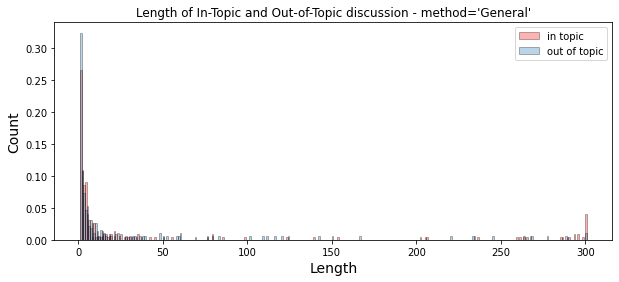

In [93]:
in_topic = []
out_topic = []

for x in simulation_reports:
    # print(x.to_string())
    in_, out_ = split_topics(x["Topic Divergence"].astype(int))
    in_topic += in_
    out_topic += out_

plot_topic_histogram(in_topic, out_topic, method = "Old", normalised = False)
plot_topic_histogram(in_topic, out_topic, method = "Old", normalised = True)

## Concat Sim files

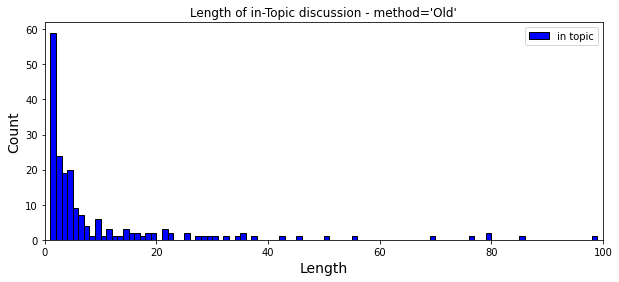

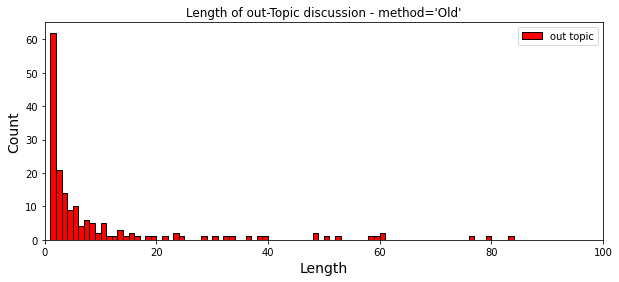

In [27]:
folder = "outputs/sim_0.45_old"

in_topic = []
out_topic = []

for i in range(50):
    curr_path = f"{folder}/{i}.csv"    
    # print(x.to_string())
    
    df = pd.read_csv(curr_path)
    
    in_, out_ = split_topics(df["Topic Divergence"].astype(int))
    in_topic += in_
    out_topic += out_

plot_one_topic_histogram(in_topic, "in", method = "Old", normalised = False)
plot_one_topic_histogram(out_topic, "out", method = "Old", normalised = False)

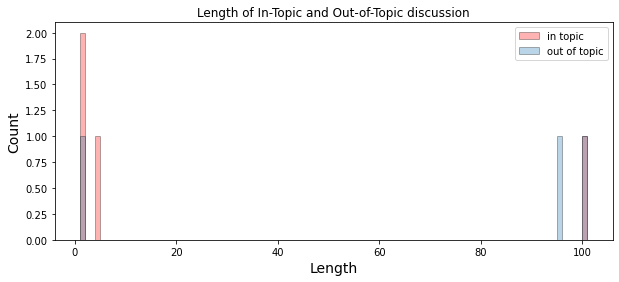

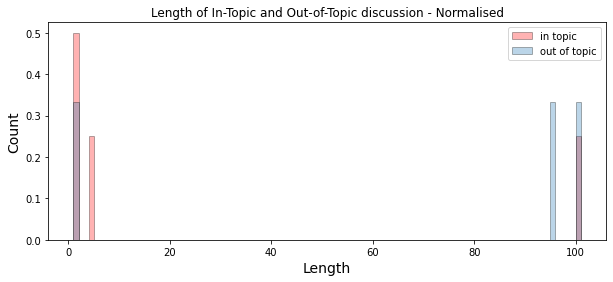

In [66]:
in_topic = []
out_topic = []


# print(f"results\n{in_topic=}\n{out_topic=} ")

fig = plt.figure(figsize=(10,4))
fig.patch.set_facecolor('white')

common_params = {
   "bins" : range(min(in_topic), max(in_topic) + 1, 1),
   "edgecolor" : "black",
   "alpha" : 0.3,
   # "density" : True
}

plt.hist(in_topic, label="in topic", color="red", **common_params)
plt.hist(out_topic, label="out of topic", **common_params)
plt.xlabel("Length", size=14)
plt.ylabel("Count", size=14)
plt.title("Length of In-Topic and Out-of-Topic discussion")
plt.legend(loc='upper right')
plt.show()

fig = plt.figure(figsize=(10,4))
fig.patch.set_facecolor('white')


common_params = {
   "bins" : range(min(in_topic), max(in_topic) + 1, 1),
   "edgecolor" : "black",
   "alpha" : 0.3,
   "density" : True
}

plt.hist(in_topic, label="in topic", color="red", **common_params)
plt.hist(out_topic, label="out of topic", **common_params)
plt.xlabel("Length", size=14)
plt.ylabel("Count", size=14)
plt.title("Length of In-Topic and Out-of-Topic discussion - Normalised")
plt.legend(loc='upper right')
plt.show()

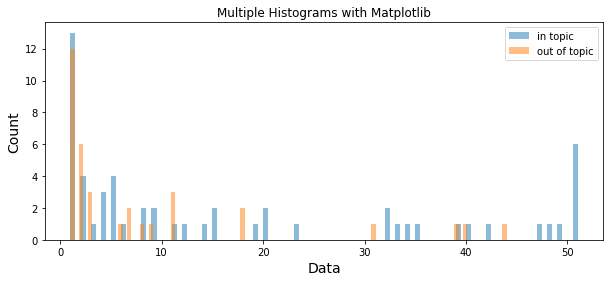

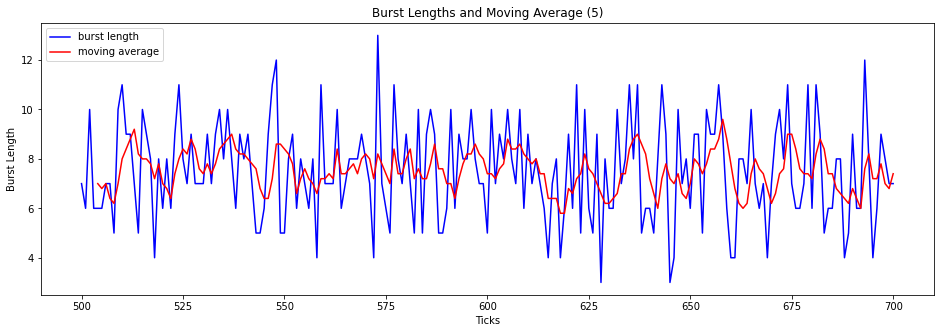

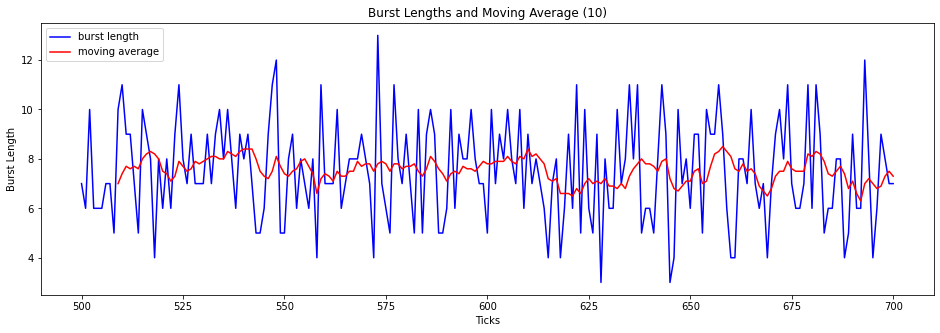

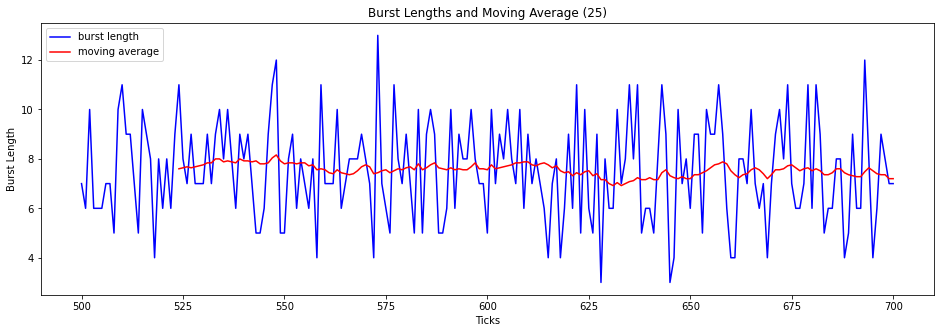

In [34]:
iterations = 200
repeat_report = netlogo.repeat_report(["length last [board_history] of one-of boards"], iterations)

for window_size in [5,10,25]:
    roll = repeat_report.rolling(window=window_size).mean()

    plt.figure(figsize=(16, 5))
    plt.plot(repeat_report, 'b-', label='burst length')
    plt.plot(roll, 'r-', label='moving average')

    plt.title(f"Burst Lengths and Moving Average ({window_size})")
    plt.ylabel('Burst Length')
    plt.xlabel('Ticks')
    plt.legend(loc='upper left')
    plt.show()

def graph_burst_length(burst_length_data):
    """
    burst_length_data : Series
        lengths of bursts by tick
    """
    roll = burst_length_data.rolling(window=5).mean()

    plt.figure(figsize=(16, 5))
    plt.plot(burst_length_data, 'b-', label='burst length')
    plt.plot(roll, 'r-', label='moving average')

    plt.title("Burst Lengths and Moving Average (5 ticks)")
    plt.ylabel('Burst Length')
    plt.xlabel('Ticks')
    plt.legend(loc='upper left')
    plt.show()

<AxesSubplot:title={'center':'Gender Participation / Tick'}, xlabel='Tick', ylabel='Gender Participation'>

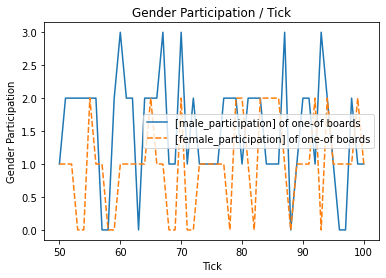

In [5]:
netlogo.command("set female_prob_exploit 0.5")
netlogo.command("set male_prob_exploit 0.3")

iterations = 50
report = netlogo.repeat_report(\
    ["[male_participation] of one-of boards", "[female_participation] of one-of boards"],
    iterations)

fig, ax = plt.subplots()
ax.set_xlabel("Tick")
ax.set_ylabel("Gender Participation")
plt.title("Gender Participation / Tick")
sns.lineplot(data=report.iloc[:])

# report.iloc[0] get by tick

### Graphs

In [6]:
def plot_1d_arr(arr, ylabel, aspect=70):
    df = pd.DataFrame(arr)

    fig, ax = plt.subplots()
    ax.set_aspect(aspect)
    ax.set_xlabel("Tick")
    ax.set_ylabel(ylabel)
    fig.patch.set_facecolor('white')
    plt.title(f"{ylabel} / Tick")

    sns.lineplot(data=df, x=range(len(arr)), y=df[0])
    # print(df.describe())

## Helper

### Manage Simulation

In [35]:
def show_sim_stats():
    """prints graph pertaining to the ran simulation"""
    iterations = 50
    male_part, female_part, topic_divergence, true_ratio, burst_lengths = netlogo.repeat_report(\
        ["[male_participation] of one-of boards", "[female_participation] of one-of boards", "compat_ratio", "[ratio] of one-of boards", "length last [board_history] of one-of boards"],\
    iterations)

    plot_1d_arr(female_part, ylabel="F Participation")
    plot_1d_arr(male_part, ylabel="M Participation")
    plot_1d_arr(netlogo.report("burst-length-report"), ylabel="Burst Length", aspect=20)
    graph_burst_length(burst_lengths)

### Setup Scenarios

In [8]:
# Scenario:sub-scenario : [Attention Norm, females, males, female_prob_exploit, male_prob_exploit]
scenarios = {
    # Working class
    1.1 : ["General", 1, 1, 0.45, 0.25],
    1.2 : ["General", 2, 1, 0.45, 0.25],
    1.3 : ["General", 1, 2, 0.45, 0.25],
    1.4 : ["Gendered", 2, 1, 0.45, 0.25],
    1.5 : ["Gendered", 1, 2, 0.45, 0.25],
    
    # Upper class
    2.1 : ["General", 1, 1, 0.85, 0.8],
    2.2 : ["General", 2, 1, 0.85, 0.8],
    2.3 : ["General", 1, 2, 0.85, 0.8],
    2.4 : ["Gendered", 2, 1, 0.85, 0.8],
    2.5 : ["Gendered", 1, 2, 0.85, 0.8],

    # Middle class
    3.1 : ["General", 1, 1, 0.6, 0.5],
    3.2 : ["General", 2, 1, 0.6, 0.5],
    3.3 : ["General", 1, 2, 0.6, 0.5],
    3.4 : ["Gendered", 2, 1, 0.6, 0.5],
    3.5 : ["Gendered", 1, 2, 0.6, 0.5],   
}

In [9]:
# old scenarios
# scenarios = {
#     # Scenario:sub-scenario : [Attentio Norm, females, males, female_prob_exploit, male_prob_exploit]
#     # Working class
#     1.1 : ["General", 1, 1, 0.65, 0.25],
#     1.2 : ["General", 2, 1, 0.65, 0.25],
#     1.3 : ["Gendered", 2, 1, 0.65, 0.25],
    
#     # Middle class
#     2.1 : ["General", 1, 1, 0.7, 0.5],
#     2.2 : ["General", 2, 1, 0.7, 0.5],
#     2.3 : ["Gendered", 2, 1, 0.7, 0.5],
    
#     # Upper class
#     3.1 : ["General", 1, 1, 0.85, 0.75],
#     3.2 : ["General", 2, 1, 0.85, 0.75],
#     3.3 : ["Gendered", 2, 1, 0.85, 0.75],
# }

# run_scenario(*scenarios[1.1], 1.1, 50)

## Run Simulation (Normal Divergence)

### Topic Divergence (-1 / 1)

In [10]:
def plot_topic(indexes, data, in_out, scenario):

    if in_out not in ["in", "out", "polarised"]: 
        print("invalid in / out")
        return
    
    topic_print = 'In-Topic' if in_out == 'in' else 'Out-of-Topic' if in_out == 'out' else 'Polarised'
    
    plt.ylabel("Count")

    plt.xlabel(f"{topic_print} Length")

    plt.title(f"{scenario} Lengths of {topic_print} Discussions")
    plt.bar(indexes, list(data.values()))
    plt.xticks(indexes, list(data.keys()))

    plt.savefig(f"plots/{scenario}_{in_out}_topic.png")
    plt.show()

In [11]:
# concat all in/out of topic lengths
def read_in_topic(scenario, divergency):

    if divergency:
        file_path = f"outputs/{scenario}_compat_ratios.csv"
    else:
        file_path = f"outputs/{scenario}_topic_data.csv"

    in_topic = []
    out_topic = []

    with open(file_path) as fp:
        
        for l in fp.readlines():
            # -1 -> 0 | 1 -> 1
            # print(l.split())
            # lst = [e for e in l if e.isalnum() or e == "-1"]
            lst = [e for e in l.split(",")]
            print(f"{lst=}")
            topics = split_topics(lst)
            out_topic += topics[0]
            in_topic += topics[1]

    return out_topic, in_topic

def run_scenario(method, females, males, f_exploit, m_exploit, scenario, iterations = 5):
    file_path = f"outputs/{scenario}_compat_ratios.csv"
    if os.path.exists(file_path): os.remove(file_path) # reset file

    netlogo.command(f'set Method "Attention Norm - {method}"')
    netlogo.command(f'set females {females}')
    netlogo.command(f'set males {males}')
    netlogo.command(f'set female_prob_exploit {f_exploit}')
    netlogo.command(f'set male_prob_exploit {m_exploit}')

    for _ in range(iterations):
        netlogo.command("setup")
        netlogo.command("repeat 50 [go]")

        messages = netlogo.report("compat-ratio-report").astype(int)
        with open(file_path, "a+") as fp:
            # fp.write(f"{[x for x in messages]}")
            fp.write(','.join(str(x) for x in messages))
            fp.write("\n")

    # return the length counts for in/out topic
    out_topic, in_topic = read_in_topic(scenario, divergency = True)

    return  dict(sorted(Counter(out_topic).items())), dict(sorted(Counter(in_topic).items())), 


def show_topic_divergence(scenario):
    topic = [[],[]]

    messages = netlogo.report("get-in-topic").astype(int)
    # should_be = [[2, 1, 3], [3, 1, 1, 4]]

    with open(f"plots/{scenario}_in-topic-data.csv", "a+") as fp:
        fp.write(f"{list(messages)}")
        fp.write("\n")
    
    prev_compat = False

    for curr_compat in messages:
        
        if prev_compat == curr_compat: # continue last count
            topic[curr_compat][len(topic[curr_compat])-1] += 1
        else: # create new count
            topic[curr_compat].append(1)
        
        prev_compat = curr_compat

    # print(topic)

    sns.displot(topic[0], kde=True).set(title="Lengths of Out-of-Topic Discussions")
    x_ticks = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
    plt.xticks(x_ticks)

    sns.displot(topic[1], kde=True).set(title="Lengths of In-Topic Discussions")

### Run simulation

In [12]:
out_topic, in_topic = read_in_topic(2.3)

out_topic = list(map(int,out_topic))
in_topic = list(map(int,in_topic))

out_topic_counter = dict(sorted(Counter(out_topic).items()))
in_topic_counter = dict(sorted(Counter(in_topic).items()))

ind = np.arange(len(out_topic_counter))
data = out_topic_counter

scenario_id = 2.3

indexes = np.arange(len(out_topic_counter))

plot_topic(indexes, out_topic_counter, "out",  scenario_id)
plot_topic(indexes, out_topic_counter, "out",  scenario_id)

indexes = np.arange(len(in_topic_counter))

plot_topic(indexes, in_topic_counter, "in",  scenario_id)
plot_topic(indexes, in_topic_counter, "in",  scenario_id)

TypeError: read_in_topic() missing 1 required positional argument: 'divergency'

## Run Simulation Polarisation

### Topic Divergence (with Polarisation -1 / 0 / 1)

In [ ]:
def plot_from_files_polarised(scenario):
    # return the length counts for in/out topic
    out_topic, polarised_topic, in_topic = read_in_topic_polarised(scenario)
        
    out_topic_counter = dict(sorted(Counter(out_topic).items()))
    indexes = np.arange(len(out_topic_counter))
    plot_topic(indexes, out_topic_counter, "out",  scenario)
    
    in_topic_counter = dict(sorted(Counter(in_topic).items()))
    indexes = np.arange(len(in_topic_counter))
    plot_topic(indexes, in_topic_counter, "in",  scenario)

    polarised_topic_counter = dict(sorted(Counter(polarised_topic).items()))    
    indexes = np.arange(len(polarised_topic_counter))
    plot_topic(indexes, polarised_topic_counter, "polarised",  scenario)

    common_params = dict(bins=100, range=(1, 200), density = True)

    ax = plt.hist((out_topic, in_topic, polarised_topic), **common_params)
    plt.legend(["out of topic", "in topic", "polarised discussion"])
    plt.title("Type of Discussion Length")
    plt.ylabel("Prevalence")
    plt.xlabel("Length of Discussion")

In [ ]:
# compat-ratio-report-with-polarisation
def split_topics_polarised(messages):
    topic = [[],[],[]]
    # convert to int
    messages = [int(e) for e in messages]
    
    prev_compat = -1

    topic_indexes = {
        -1 : 0,
        0 : 1,
        1 : 2,
    }

    for curr_compat in messages:
        index = topic_indexes[curr_compat]
        
        if prev_compat == curr_compat: # continue last count    
            topic[index][len(topic[index]) - 1] += 1
        else: # create new count
            topic[index].append(1)
        
        prev_compat = curr_compat
    
    # print(topic)
    return topic

# concat all in/out of topic lengths
def read_in_topic_polarised(scenario):
    file_path = f"outputs/{scenario}_compat_ratios_polarisation.csv"

    in_topic = []
    out_topic = []
    polarised_topic = []

    with open(file_path) as fp:
        
        for l in fp.readlines():
            # -1 -> 0 | 1 -> 1
            # print(l.split())
            # lst = [e for e in l if e.isalnum() or e == "-1"]
            lst = [e for e in l.strip("\n").split(",")]
            # print(f"{lst=}")
            topics = split_topics_polarised(lst)
            out_topic += topics[0]
            polarised_topic += topics[1]
            in_topic += topics[2]

    return out_topic, polarised_topic, in_topic

def run_scenario_polarised(method, females, males, f_exploit, m_exploit, scenario, iterations = 1):
    file_path = f"outputs/{scenario}_compat_ratios_polarisation.csv"
    if os.path.exists(file_path): os.remove(file_path) # reset file

    netlogo.command(f'set Method "Attention Norm - {method}"')
    netlogo.command("set number_of_agents 15")
    netlogo.command(f'set females {females}')
    netlogo.command(f'set males {males}')
    netlogo.command(f'set female_prob_exploit {f_exploit}')
    netlogo.command(f'set male_prob_exploit {m_exploit}')

    for _ in range(iterations):    
        netlogo.command("setup")
        # netlogo.command("repeat 200 [go]")

        # messages = netlogo.report("compat-ratio-report-with-polarisation").astype(int)
        # messages = netlogo.repeat_report("compat_ratio", 200)
        report = netlogo.repeat_report(["[ratio] of one-of boards", "compat_ratio", "[male_participation] of one-of boards", "[female_participation] of one-of boards"], 20)
        report.to_csv(f"outputs/{scenario}_report.csv")
        # with open(file_path, "a+") as fp:
        #     fp.write(','.join(str(x) for x in messages))
        #     fp.write("\n")
    
    print(f"{scenario=} done")

In [ ]:
netlogo.command("setup")
# abou = netlogo.repeat_report("compat_ratio", 2)
# abou.to_csv("abou.csv")
# abou

### Run Simulation

In [ ]:
# for x in ["[ratio] of one-of boards", "compat_ratio", "divergencies_from_first_ku", "[male_participation] of one-of boards", "[female_participation] of one-of boards"]:
#     print(f"length of {x}")
netlogo.command("set number_of_agents 15")
netlogo.command("setup")

In [ ]:
report = netlogo.repeat_report(["[ratio] of one-of boards", "compat_ratio", "[male_participation] of one-of boards", "[female_participation] of one-of boards"], 20)
# report_div = netlogo.repeat_report(["divergencies_from_first_ku"], 2) divergencies first element is a 0 and not a []

In [ ]:
report.to_csv("aboubakar.csv")

In [ ]:
# scenario_ids = [1.2, 2.2, 2.3]
# for s in scenario_ids:
    # run_scenario_polarised(*scenarios[s], s)
run_scenario_polarised(*scenarios[1.1], 1.1, iterations=1)

In [ ]:
# messages = netlogo.report("compat-ratio-report").astype(int)
# file_path = f"outputs/1.1_compat_ratios.csv"
    
# with open(file_path, "a+") as fp:
#     fp.write(','.join(str(x) for x in messages))
#     fp.write("\n")

In [ ]:
reduced_scenarios = {
    # Working class
    1.1 : ["General", 1, 1, 0.45, 0.25],
    1.5 : ["Gendered", 1, 2, 0.45, 0.25],
    
    # Upper class    
    2.1 : ["General", 1, 1, 0.85, 0.8],
    2.5 : ["Gendered", 1, 2, 0.85, 0.8],
}

# run 3 scenarios
for scenario_id,v in reduced_scenarios.items():
    out_topic_counter, in_topic_counter = run_scenario(*v, scenario_id, 1)

    # sort
    out_topic_counter = dict(sorted(out_topic_counter.items()))
    in_topic_counter = dict(sorted(in_topic_counter.items()))

    indexes = np.arange(len(out_topic_counter))

    plot_topic(indexes, out_topic_counter, "out",  scenario_id)

    indexes = np.arange(len(in_topic_counter))

    plot_topic(indexes, in_topic_counter, "in",  scenario_id)

# TODO - NORMALIZED HISTOGRAM